# Multimodal Integration
COMP386 Final Project by Angie Georgaras. Code for modalities adapted from projects completed by students in Dr. Albert's Fall COMP386 class. 

In [204]:
#packages used throughout the notebook
import numpy as np
import pylab as py #for plotting 
%matplotlib inline 
#shows plots in notebook
from IPython.display import Image, Audio
import math
import sklearn.decomposition #for ICA and PCA algorithms 
import PIL
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import pylab
from scipy import ndimage
import wave
import sys
import random as random

# Background and Motivation

We are constantly taking in sensory information, across several different modalities. For the purposes of this assignment I am going to focus on black and white images, color images, and sounds. 


The initial route that visual and auditory info travels into our brains differs. For vision, we take in info via light through the eyes, down the optic nerve, to the optic chiasm, then to the lateral geniculate nucleus, and then to the first place in the cortex that visual info is processed: in the primary visual cortex. (V1)

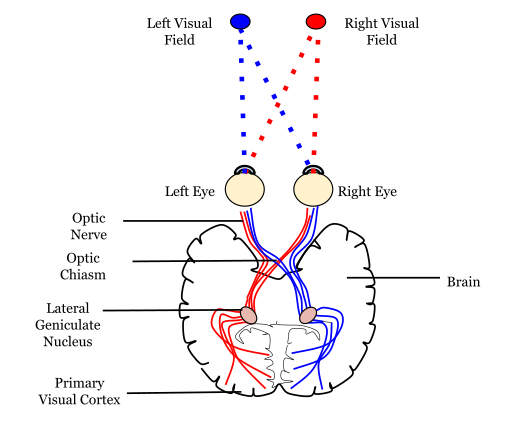

In [205]:
Image(filename="v1.png")

V1 simple cell receptive fields are particularly sensitive to planar sinusoids of specific locations, orientations, spatial frequencies, and phases.  This response resembles a 2D gabor filter, which is a planar sine wave in a gaussian envelope. Below are two V1 filters that respond to different patterns of visual input.

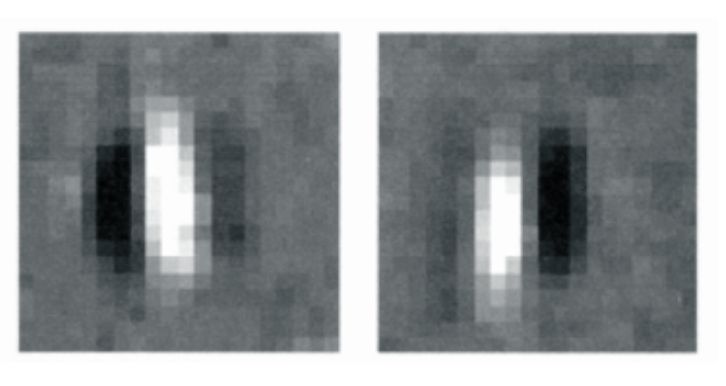

In [206]:
Image(filename='gabor.png')

To better visualize this concept of V1 receptive fields, below is an example of a 2D gabor filter that is sensitive to vertical lines applied over an image of a forest. This displays the potential response of a V1 simple cell that is sensitive to vertical lines.

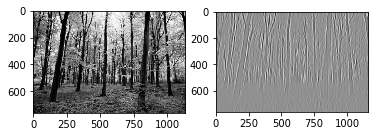

In [207]:
img_1 = mpimg.imread('tree.png')
img_2 = mpimg.imread('gabortree.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);

For auditory info, we see sound go into the ear, past hair cells in the cochlea, to the first place sound is processed: precortically in the auditory nerve. (spiral ganglion axons) 

Here, the receptive field response that we see is a gammatone filter, which is a linear filter that is produced by a gamma distribution and a sinusoidal tone. Below on the right is an example of what this looks like.

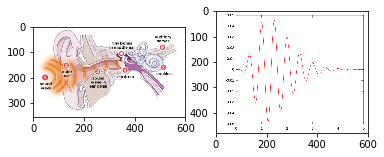

In [208]:
img_1 = mpimg.imread('ear.jpg')
img_2 = mpimg.imread('gamma.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);

While different in name, the gammatone filter is strikingly similar to the 2D Gabor filter shown in V1 simple cells in that these specific shapes are the results of efficient coding. This concept is known as the efficient coding hypothesis, which serves to explain how our brains represent and process sensory input. 

What do we mean when we say efficient? It depends on what we're looking at. For a computer, efficiency often means compression, which in the brain would translate to minimizing the number of neurons firing. This is well represented by PCA (Principal Components Analysis) which is a machine learning algorithm that searches for important components in data to explain its variance. While this is efficient for a computer in minimizing resources spent on computation, this is not how the brain works. In the brain, instead of compression we see independent coding, which aims to reduce redundancy between neurons and have them be independent from one another in processing. This is represented by ICA (Independent Components Analysis) which searches for features that are statistically independent.

So across two different sensory modalities, vision and hearing, that are located in different parts of the brain, information processing is done by the exact same algorithm that we can represent with ICA. 

# Black and White Images

To show how the same algorithm is being used across modalities, we're going to first look at black and white images. We are going to collect samples from these two natural images, and apply PCA and ICA to them to contrast filter responses.

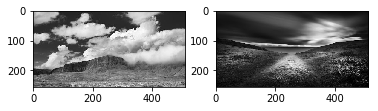

In [209]:
img_1 = mpimg.imread('BW/natural/1.jpg')
img_2 = mpimg.imread('BW/natural/2.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);

In [210]:
#this function collects patches from these two natural images for later processing
def collectPatches(numPatches, patchWidth):
    maxTries = numPatches * 50
    
    firstPatch = 0 # the first patch number accepted from an image
    firstTry = 0 # the first attempt to take a patch from the image
    patchCount = 0 # number of collected patches
    tryCount = 0 # number of attempted collected patches
    numPixels = patchWidth * patchWidth
    
    patchSample = np.zeros([patchWidth,patchWidth],'double')
    patch = np.zeros([numPixels,1],'double')
    
    imgPatches = np.zeros([numPixels,numPatches],'double')
                                                 
    # change the image sampled from
    imgCount = 1  
    image = PIL.Image.open('BW/natural/' + str(imgCount) + '.jpg')
    imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread('BW/natural/' + str(imgCount) + '.jpg').shape
    image = image.convert('L')
    image = np.asarray(image, 'double').transpose()
    # normalizing the image
    image -= image.mean()
    image /= image.std()
    
    # K, now I got the image, time to get patches
    
    while patchCount < numPatches and tryCount < numPatches:
        tryCount += 1
        
        if (tryCount - firstTry) > maxTries/2 or (patchCount - firstPatch) > numPatches/2:
        # change the image sampled from
            imgCount += 1
            image = PIL.Image.open('BW/natural/' + str(imgCount) + '.jpg')
            imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread('BW/natural/' + str(imgCount) + '.jpg').shape
            image = image.convert('L')
            image = np.asarray(image, 'double').transpose()
            # normalizing the image
            image -= image.mean()
            image /= image.std()
      
            firstPatch = patchCount
            firstTry = tryCount
    
            # update on every switch of images
            print (int(100 * float(patchCount)/numPatches),' percent complete')
        
        
        px = np.random.randint(0,imageWidth - patchWidth)
        py = np.random.randint(0,imageHeight - patchWidth)

        patchSample = image[px:px+patchWidth,py:py+patchWidth].copy()
        patchStd = patchSample.std()

        if patchStd > 0.0: # > 0 to remove blank/uninteresting patches for speed
            # create the patch vector    
            patch = np.reshape(patchSample, numPixels)     
            patch = patch - np.mean(patch)         
            imgPatches[:,patchCount] = patch.copy()
            patchCount += 1
            
    return imgPatches

patchesMat = collectPatches(50000, 16)
print('\nshape of the extracted image patch data:', patchesMat.shape)  

50  percent complete

shape of the extracted image patch data: (256, 50000)


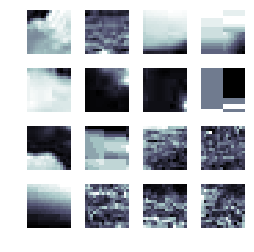

In [211]:
#this function shows the patches previously collected that we'll be running PCA and ICA on
def showPatchesMat(prePatches, showPatchNum = 16, display=True):
    patches = prePatches

    totalPatches = patches.shape[1]
    dataDim = patches.shape[0]
    patchWidth = int(np.round(np.sqrt(dataDim)))

    # extract show_patch_num patches
    displayPatch = np.zeros([dataDim, showPatchNum], float)
    for i in range(0,showPatchNum):
        patch_i = i * totalPatches // showPatchNum

        patch = patches[:,patch_i].copy()
        pmax  = patch.max()
        pmin = patch.min()
        # fix patch range from min to max to 0 to 1
        if pmax > pmin: 
            patch = (patch - pmin) / (pmax - pmin)
        displayPatch[:,i] = patch.copy()

    bw = 5    # border width
    pw = patchWidth

    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImg = displayPatch.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)
    for i in range(0,showPatchNum):
        y_i = i // patchesY
        x_i = i % patchesY

        reshaped = displayPatch[:,i].reshape((pw,pw))
        fullPatch = np.zeros([pw, pw], float)
        fullPatch[0:pw,:] = reshaped[:,:].copy()
        patchImg[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatch

    if display:
        py.bone()
        py.imshow(patchImg.T, interpolation='nearest')
        py.axis('off')
        
    return

showPatchesMat(patchesMat)

Now that we've collected the sample patches, we're going to run PCA and ICA on them to show filter responses.

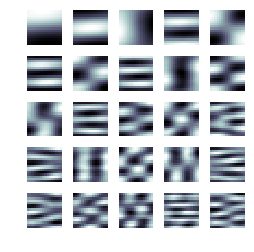

In [212]:
# finding PCA components

pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(np.transpose(patchesMat))

pca_comp = pcafit.components_
showPatchesMat(np.transpose(pca_comp), 25)

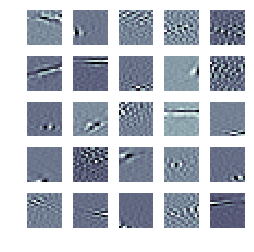

In [213]:
# finding ICA components

icatemp = sklearn.decomposition.FastICA(n_components=175)
icafit = icatemp.fit(np.transpose(patchesMat))

ica_comp = icafit.components_

showPatchesMat(np.transpose(ica_comp), 25)

Note that while the PCA's results don't look like anything in particular, the results of running ICA on these samples actually shows what looks like the V1 receptive fields that we saw earlier, like a 2D gabor filter.

The brain is used to making sense of natural images, meaning things our brains have been exposed to over and over again while evolving, such as trees. What happens if instead of running PCA and ICA on natural images, we instead run them on unnatural images?

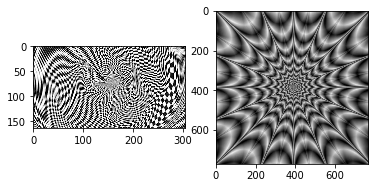

In [214]:
img_1 = mpimg.imread('BW/unnatural/1.jpg')
img_2 = mpimg.imread('BW/unnatural/2.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);
    

In [215]:
#this function collects patches from these two natural images for later processing
def collectPatches(numPatches, patchWidth):
    maxTries = numPatches * 50
    
    firstPatch = 0 # the first patch number accepted from an image
    firstTry = 0 # the first attempt to take a patch from the image
    patchCount = 0 # number of collected patches
    tryCount = 0 # number of attempted collected patches
    numPixels = patchWidth * patchWidth
    
    patchSample = np.zeros([patchWidth,patchWidth],'double')
    patch = np.zeros([numPixels,1],'double')
    
    imgPatches = np.zeros([numPixels,numPatches],'double')
                                                 
    # change the image sampled from
    imgCount = 1  
    image = PIL.Image.open('BW/unnatural/' + str(imgCount) + '.jpg')
    imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread('BW/unnatural/' + str(imgCount) + '.jpg').shape
    image = image.convert('L')
    image = np.asarray(image, 'double').transpose()
    # normalizing the image
    image -= image.mean()
    image /= image.std()
    
    # K, now I got the image, time to get patches
    
    while patchCount < numPatches and tryCount < numPatches:
        tryCount += 1
        
        if (tryCount - firstTry) > maxTries/2 or (patchCount - firstPatch) > numPatches/2:
        # change the image sampled from
            imgCount += 1
            image = PIL.Image.open('BW/unnatural/' + str(imgCount) + '.jpg')
            imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread('BW/unnatural/' + str(imgCount) + '.jpg').shape
            image = image.convert('L')
            image = np.asarray(image, 'double').transpose()
            # normalizing the image
            image -= image.mean()
            image /= image.std()
      
            firstPatch = patchCount
            firstTry = tryCount
    
            # update on every switch of images
            print (int(100 * float(patchCount)/numPatches),' percent complete')
        
        
        px = np.random.randint(0,imageWidth - patchWidth)
        py = np.random.randint(0,imageHeight - patchWidth)

        patchSample = image[px:px+patchWidth,py:py+patchWidth].copy()
        patchStd = patchSample.std()

        if patchStd > 0.0: # > 0 to remove blank/uninteresting patches for speed
            # create the patch vector    
            patch = np.reshape(patchSample, numPixels)     
            patch = patch - np.mean(patch)         
            imgPatches[:,patchCount] = patch.copy()
            patchCount += 1
            
    return imgPatches

patchesMat = collectPatches(50000, 16)
print('\nshape of the extracted image patch data:', patchesMat.shape) 

50  percent complete

shape of the extracted image patch data: (256, 50000)


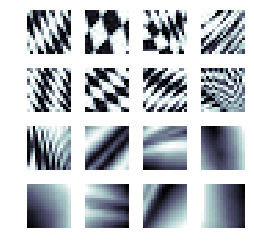

In [216]:
#this function shows the patches previously collected that we'll be running PCA and ICA on
def showPatchesMat(prePatches, showPatchNum = 16, display=True):
    patches = prePatches

    totalPatches = patches.shape[1]
    dataDim = patches.shape[0]
    patchWidth = int(np.round(np.sqrt(dataDim)))

    # extract show_patch_num patches
    displayPatch = np.zeros([dataDim, showPatchNum], float)
    for i in range(0,showPatchNum):
        patch_i = i * totalPatches // showPatchNum

        patch = patches[:,patch_i].copy()
        pmax  = patch.max()
        pmin = patch.min()
        # fix patch range from min to max to 0 to 1
        if pmax > pmin: 
            patch = (patch - pmin) / (pmax - pmin)
        displayPatch[:,i] = patch.copy()

    bw = 5    # border width
    pw = patchWidth

    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImg = displayPatch.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)
    for i in range(0,showPatchNum):
        y_i = i // patchesY
        x_i = i % patchesY

        reshaped = displayPatch[:,i].reshape((pw,pw))
        fullPatch = np.zeros([pw, pw], float)
        fullPatch[0:pw,:] = reshaped[:,:].copy()
        patchImg[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatch

    if display:
        py.bone()
        py.imshow(patchImg.T, interpolation='nearest')
        py.axis('off')
        
    return

showPatchesMat(patchesMat)

Once again we've collected the sample patches, so lets run PCA and ICA on them to show the filters.

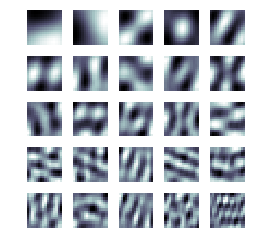

In [217]:
# finding PCA components

pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(np.transpose(patchesMat))

pca_comp = pcafit.components_
showPatchesMat(np.transpose(pca_comp), 25)

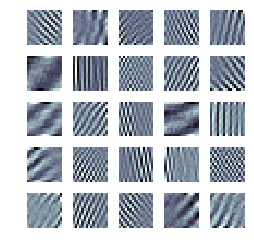

In [218]:
# finding ICA components

icatemp = sklearn.decomposition.FastICA(n_components=175)
icafit = icatemp.fit(np.transpose(patchesMat))

ica_comp = icafit.components_

showPatchesMat(np.transpose(ica_comp), 25)

Here, we can see that while the filters formed from running PCA are similar to the ones produced by natural images, the ones from running ICA, the more neural-like algorithm, we don't see any neuronal receptive field filters. 

# Color Images

Now we're going to do the same thing that we did above, but now with full color natural and unnatural images.

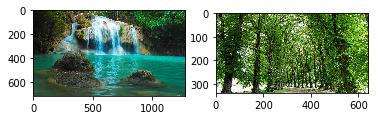

In [219]:
img_1 = mpimg.imread('color/natural/1.jpg')
img_2 = mpimg.imread('color/natural/2.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);
    

Natural images patch sampling and display

In [220]:
#this function collects patches from the natural images
def collect_natural_patches_c(num_patches = 100000, patch_width = 8):

  max_tries = num_patches * 50
  image_width = 200
  
  img_first_patch = 0 # the first patch number accepted from an image
  img_first_try = 0 # the first attempt to take a patch from the image
  patch_cnt = 0 # number of collected patches
  try_cnt = 0 # number of attempted collected patches
  num_pixels = 3 * patch_width * patch_width

  patch_sample = np.zeros([3,patch_width,patch_width],float)
  patch = np.zeros([num_pixels],float)
  
  img_patches = np.zeros([num_pixels,num_patches],float)

  # this changes the image we're sampling from
  nat_img_cnt = 1  
  image = PIL.Image.open('color/natural/' + str(nat_img_cnt) + '.jpg')
  image = np.asarray(image, 'double').transpose() 
  image = image[0:3,:,:]
  # normalizing the image
  image -= image.mean()
  image /= image.std()
  
  
  # collect the patches
  while patch_cnt < num_patches and try_cnt < max_tries:
    try_cnt += 1  # number of total patches attempted

    if (try_cnt - img_first_try) > max_tries/2 or \
      (patch_cnt - img_first_patch) > num_patches/2: 
      nat_img_cnt += 1 #this switches to the next image we're sampling from!
      image = PIL.Image.open('color/natural/' + str(nat_img_cnt) + '.jpg')
      
      image = np.asarray(image, 'double').transpose() 
      image = image[0:3,:,:]
      
      
      image -= image.mean()
      image /= image.std()
      
      img_first_patch = patch_cnt
      img_first_try = try_cnt
    
      # update on every switch of images
      print (int(100 * float(patch_cnt)/num_patches),' percent complete')
    
    px = np.random.randint(0,image_width - patch_width)
    py = np.random.randint(0,image_width - patch_width)
        
    patch_sample = image[:,px:px+patch_width,py:py+patch_width].copy()
    
    patch_std = patch_sample.std()
    
    if patch_std > 0.0: # > 0 to remove blank/uninteresting patches for speed
      # create the patch vector     
      patch = np.reshape(patch_sample, num_pixels)   
      patch = patch - np.mean(patch)         
      img_patches[:,patch_cnt] = patch.copy()
      patch_cnt += 1
  return img_patches
        
patches_mat_c = collect_natural_patches_c(num_patches = 100000, patch_width = 8)
print('\nshape of the extracted image patch data:', patches_mat_c.shape)


50  percent complete

shape of the extracted image patch data: (192, 100000)


In [221]:
#this function shows the patches collected in the previous function
def show_patches_mat_c(pre_patches, show_patch_num = 16, display=True):
  
  patches = pre_patches
    
  tot_patches = patches.shape[1]
  data_dim = patches.shape[0]
  patch_width = int(np.round(np.sqrt(data_dim))) - 6
  
  # extract show_patch_num patches
  disp_patch = np.zeros([data_dim, show_patch_num], float)
  for i in range(0,show_patch_num):
    patch_i = i * tot_patches // show_patch_num
  
    patch = patches[:,patch_i].copy()
    pmax  = patch.max()
    pmin = patch.min()
    
    # fix patch range from min to max to 0 to 1
    if pmax > pmin: 
      patch = (patch - pmin) / (pmax - pmin)
    disp_patch[:,i] = patch.copy()

  bw = 5    # border width
  pw = patch_width 
  
  patches_y = int(np.sqrt(show_patch_num))
  patches_x = int(np.ceil(float(show_patch_num) / patches_y))
  patch_img = disp_patch.max() * np.ones([3,(pw + bw) * patches_x - bw,
    patches_y * (pw + bw) - bw], float)
  for i in range(0,show_patch_num): 
    y_i = i // patches_y
    x_i = i % patches_y 
    #reshape patch sizing 
    reshaped = disp_patch[:,i].reshape((3,8,8))
    full_patch = np.zeros([3, pw, pw], float)
    full_patch[0:3,0:8,0:8] = reshaped[:,:,:].copy()
    patch_img[:,x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = full_patch
  
  if display:
    #displays the patches
    py.imshow(patch_img[:,:,:].T, interpolation='nearest') 
    py.axis('off')
  return

50  percent complete


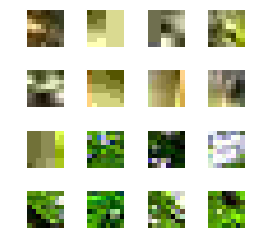

In [222]:
collect_natural_patches_c(num_patches = 100000, patch_width = 8)
show_patches_mat_c(patches_mat_c)
#this collects and displays our natural image patches that we'll run PCA and ICA on

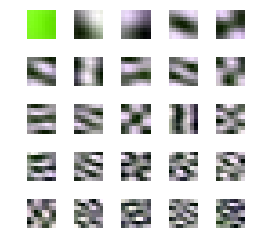

In [226]:
# finding PCA components 
pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(np.transpose(patches_mat_c))

pca_comp = pcafit.components_
show_patches_mat_c(np.transpose(pca_comp), 25)


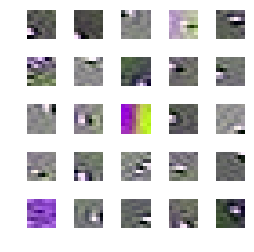

In [227]:
#finding ICA components
icatemp_c = sklearn.decomposition.FastICA(n_components=35) # note, sensitive to n_components
icafit_c = icatemp_c.fit(np.transpose(patches_mat_c))

ica_comp_c = icafit_c.components_

show_patches_mat_c(np.transpose(ica_comp_c), 25)
#these filters resemble receptive fields

Similar to what happened when we did this with black and white natural images, while we don't see anything neural with PCA, ICA creates what looks like 2D gabor filters that are selective to particular orientations in the images.

Now lets do the same with unnatural images.

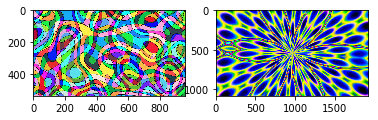

In [229]:
img_1 = mpimg.imread('color/unnatural/1.jpg')
img_2 = mpimg.imread('color/unnatural/2.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);

In [231]:
#this function collects patches from the unnatural images
def collect_unnatural_patches_c(num_patches = 100000, patch_width = 8):
  max_tries = num_patches * 50
  image_width = 200
  
  img_first_patch = 0 # the first patch number accepted from an image
  img_first_try = 0 # the first attempt to take a patch from the image
  patch_cnt = 0 # number of collected patches
  try_cnt = 0 # number of attempted collected patches
  num_pixels = 3 * patch_width * patch_width

  patch_sample = np.zeros([3,patch_width,patch_width],float)
  patch = np.zeros([num_pixels],float)
  
  img_patches = np.zeros([num_pixels,num_patches],float)

  # change the image sampled from
  unnat_img_cnt = 1  
  image = PIL.Image.open('color/unnatural/' + str(unnat_img_cnt) + '.jpg')
  image = np.asarray(image, 'double').transpose() 
  image = image[0:3,:,:]
  # normalizing the image
  image -= image.mean()
  image /= image.std()
  
  
  # collect the patches
  while patch_cnt < num_patches and try_cnt < max_tries:
    try_cnt += 1  # number of total patches attempted

    if (try_cnt - img_first_try) > max_tries/2 or \
      (patch_cnt - img_first_patch) > num_patches/2: 
      # change the image sampled from
      unnat_img_cnt += 1
      image = PIL.Image.open('color/unnatural/' + str(unnat_img_cnt) + '.jpg')
      
      image = np.asarray(image, 'double').transpose() 
      image = image[0:3,:,:]
      
      
      image -= image.mean()
      image /= image.std()
      
      img_first_patch = patch_cnt
      img_first_try = try_cnt
    
      # update on every switch of images
      print (int(100 * float(patch_cnt)/num_patches),' percent complete')
    
    px = np.random.randint(0,image_width - patch_width)
    py = np.random.randint(0,image_width - patch_width)
        
    patch_sample = image[:,px:px+patch_width,py:py+patch_width].copy()
    
    patch_std = patch_sample.std()
    
    if patch_std > 0.0: # > 0 to remove blank/uninteresting patches for speed
      # create the patch vector     
      patch = np.reshape(patch_sample, num_pixels)   
      patch = patch - np.mean(patch)         
      img_patches[:,patch_cnt] = patch.copy()
      patch_cnt += 1
  return img_patches
        
patches_mat_c = collect_unnatural_patches_c(num_patches = 100000, patch_width = 8)
print('\nshape of the extracted image patch data:', patches_mat_c.shape)

50  percent complete

shape of the extracted image patch data: (192, 100000)


50  percent complete


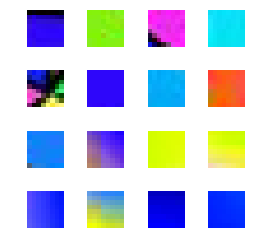

In [232]:
collect_unnatural_patches_c(num_patches = 100000, patch_width = 8)
show_patches_mat_c(patches_mat_c)
#this collects and shows our unnatural image patches that we'll run PCA and ICA on

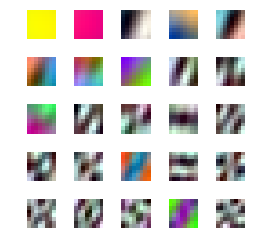

In [234]:
# finding PCA components

pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(np.transpose(patches_mat_c))

pca_comp = pcafit.components_

show_patches_mat_c(np.transpose(pca_comp), 25) #this shows 25 patches in a 5 by 5 grid


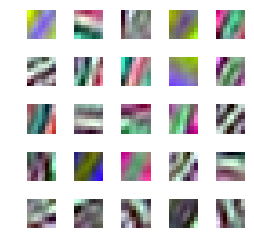

In [103]:
#finding ICA components
icatemp_c = sklearn.decomposition.FastICA(n_components=25) # note, sensitive to n_components
icafit_c = icatemp_c.fit(np.transpose(patches_mat_c))

ica_comp_c = icafit_c.components_

show_patches_mat_c(np.transpose(ica_comp_c), 25)

Similar to what we saw with black and white natural images, ICA run on unnatural images does not produce a neural-like response.

# Audio

Now to show how the same computation is performed on two different sensory modalities, lets run PCA and ICA on natural sound clips, like a dog barking, and unnatural sound clips, such as white noise.

In [237]:
Audio('audio/'+'dog.wav')

In [238]:
Audio('audio/'+'hello.wav')

In [239]:
Audio('audio/'+'tone.wav')

In [240]:
Audio('audio/'+'whitenoise.wav')

Sound Information:
Number of Samples: 445094
Hertz: 44100 Hz
Seconds: 10.09283446712018 seconds


/Users/angiegeorgaras/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/Users/angiegeorgaras/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


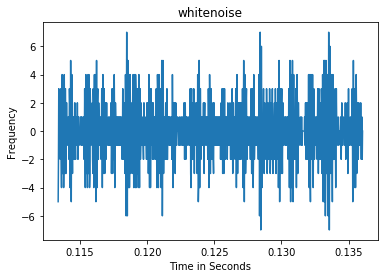

(100000, 1000)


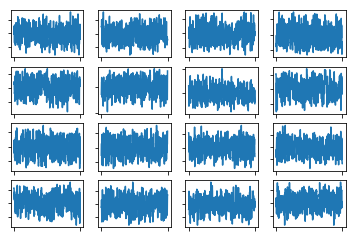

Sound Information:
Number of Samples: 170982
Hertz: 44100 Hz
Seconds: 3.8771428571428572 seconds


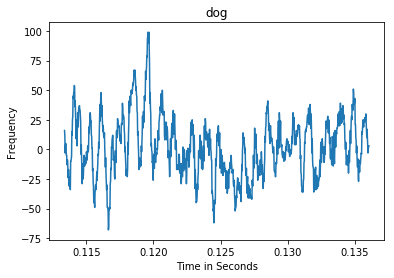

(100000, 1000)


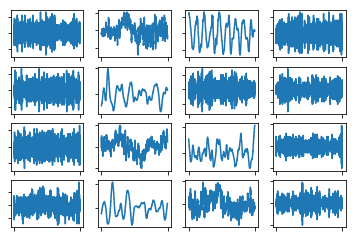

Sound Information:
Number of Samples: 442354
Hertz: 44100 Hz
Seconds: 10.030702947845805 seconds


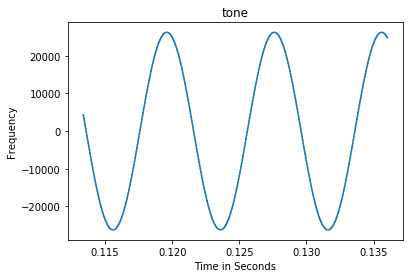

(100000, 1000)


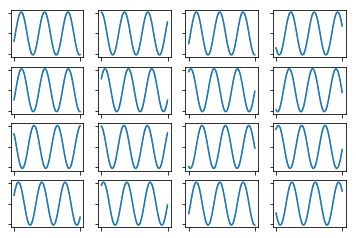

Sound Information:
Number of Samples: 115576
Hertz: 44100 Hz
Seconds: 2.6207709750566894 seconds


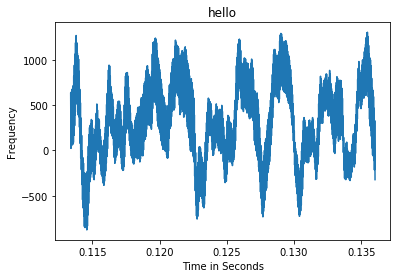

(100000, 1000)


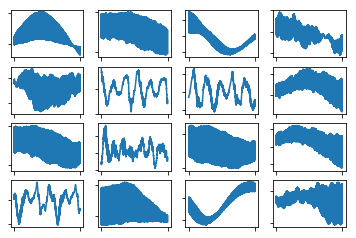

In [241]:
# opening the sound file


def load_audio(file):
    spf = wave.open('audio/' + file + '.wav','r')

    # extract raw audio from .wav file

    signal = spf.readframes(-1)
    signal = np.fromstring(signal, 'Int16')
    fs = spf.getframerate()

    # basic information printed 
    print('Sound Information:')
    print('Number of Samples:', len(signal))
    print('Hertz: %s Hz' % (fs))
    print('Seconds: %s seconds' %(len(signal)/fs))

    Time=np.linspace(0, len(signal)/fs, num=len(signal))

    # plot figure

    num_samples = len(signal)
    plt.figure(1)


    # titles
    plt.title(file)
    plt.xlabel('Time in Seconds')
    plt.ylabel('Frequency')
    start = 5000
    width = 1000
    plt.plot(Time[start:start+width],signal[start:start+width])
    plt.show()
    # plt.plot(Time, signal)

    # show figure

    plt.show()


    # making a matrix -- features by samples

    num_clips = 100000
    audio_clips = np.zeros((num_clips,width))
    for i in range(num_clips):
        x_start = np.random.randint(0,num_samples-width-2)
        audio_clips[i,:] = signal[x_start:x_start+width]


    print(audio_clips.shape)

    # show individual components

    plt.figure()
    cnt = 1
    for start in range(0,16000,1000):
        plt.subplot(4,4,cnt)
        frame = pylab.gca()
        frame.axes.get_xaxis().set_ticklabels([])
        frame.axes.get_yaxis().set_ticklabels([])
        plt.plot(range(width),audio_clips[cnt,:])
        cnt += 1

    plt.show()

    return(audio_clips)

files = ['whitenoise', 'dog', 'tone', 'hello']
all_clips = []
for file in files:
    all_clips.append(load_audio(file))

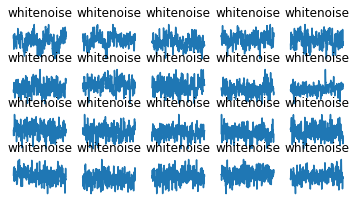

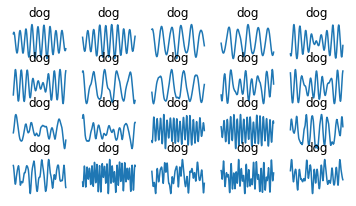

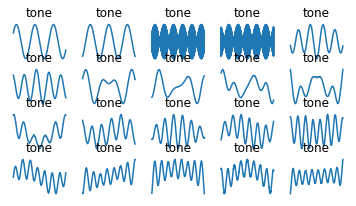

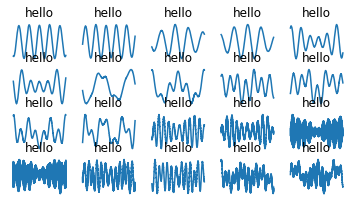

In [242]:
# finding PCA components
def pcaComponents(array, components=25):
    pcatemp = decomposition.PCA(n_components=components)
    return pcatemp.fit(array).components_

def getPCAComponents(audio_clips, file):
    pcacomp = pcaComponents(audio_clips)

    plt.figure()
    cnt = 0
    for cnt in range(20):
        plt.subplot(5, 5, cnt+1, title = file)
        frame = pylab.gca()
        frame.axes.get_xaxis().set_ticklabels([])
        frame.axes.get_yaxis().set_ticklabels([])
        plt.axis("off")
        plt.plot(range(1000),pcacomp[cnt,:])
    plt.show()
    
for (i,each) in enumerate(all_clips):
    getPCAComponents(each, files[i])

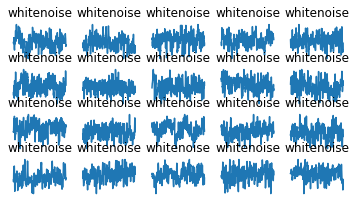

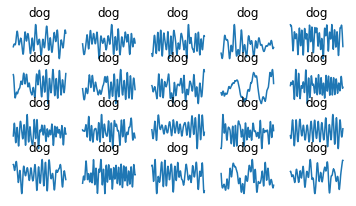

/Users/angiegeorgaras/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


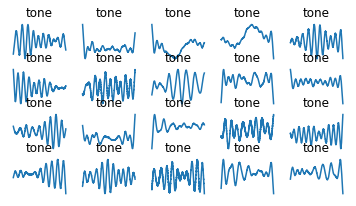

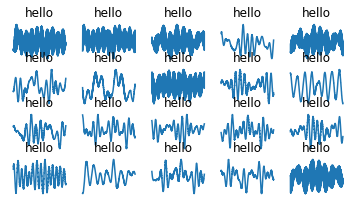

In [243]:
def icaComponents(array, components=25):
    icatemp = decomposition.FastICA(n_components=components)
    return icatemp.fit(array).components_

def getICAComponents(audio_clips, file):
    icacomp = icaComponents(audio_clips)

    plt.figure()
    cnt = 0
    for cnt in range(20):
        plt.subplot(5,5,cnt+1, title = file)
        frame = pylab.gca()
        frame.axes.get_xaxis().set_ticklabels([])
        frame.axes.get_yaxis().set_ticklabels([])
        plt.axis("off")
        plt.plot(range(1000),icacomp[cnt,:])
    plt.show()
    
for (i,each) in enumerate(all_clips):
    getICAComponents(each, files[i])

Just as what we saw with natural and unnatural images, running ICA on natural sounds results in neural-looking filters!

# Side By Side Comparisons

Despite different inputs, ICA run on various types of input from several sensory modalities all produces neural responses, showing that the same computation is performed. Below are visuals comparing these results to one another.

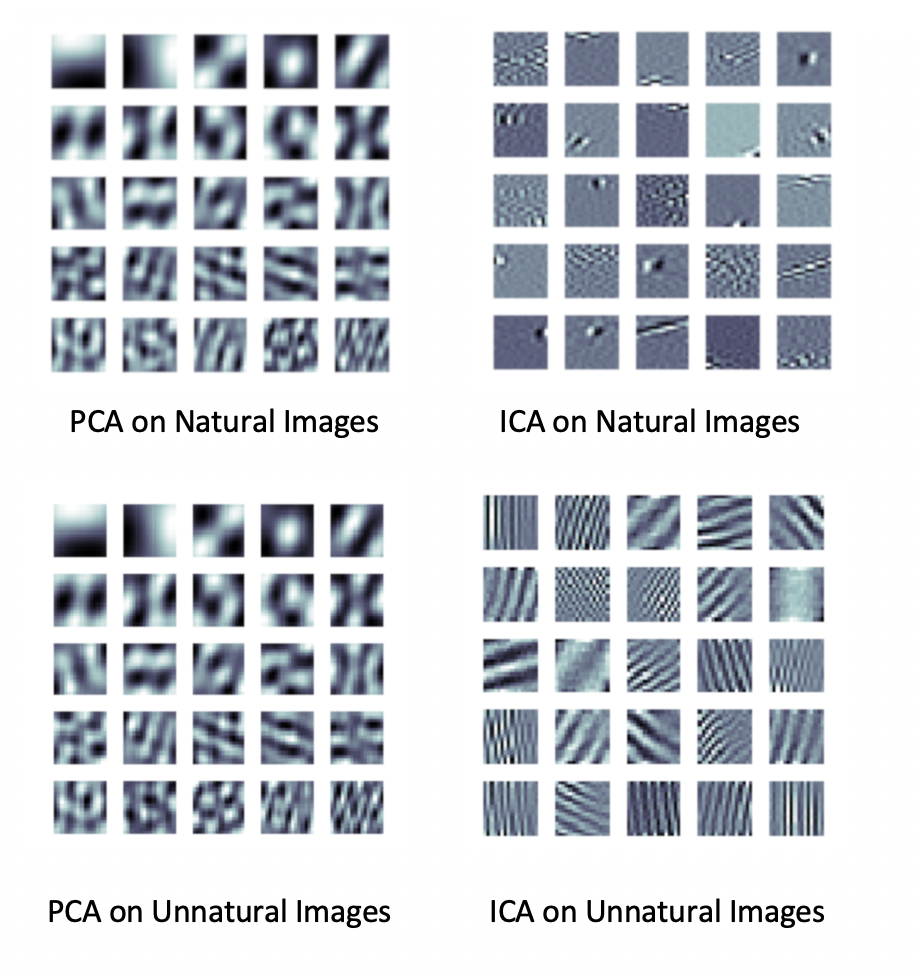

In [191]:
Image(filename="bwresults.png")

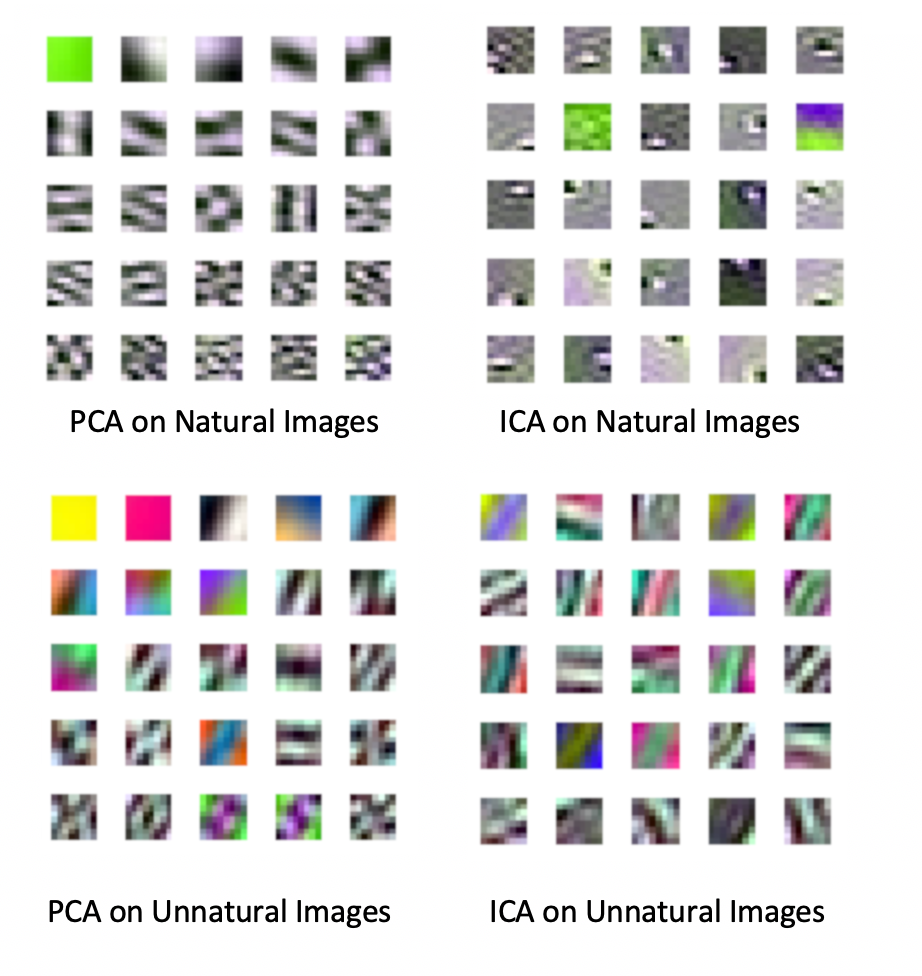

In [192]:
Image(filename="colorresults.png")

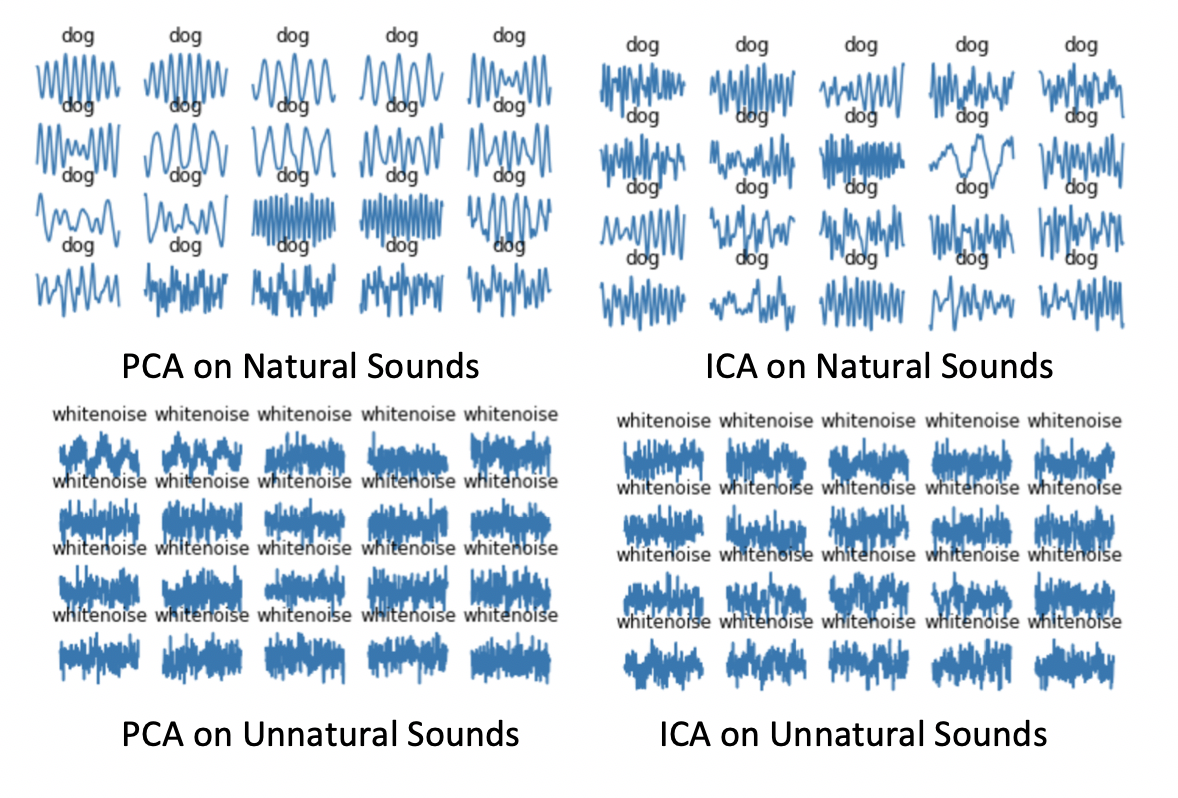

In [193]:
Image(filename="soundresults.png")